In [55]:
import sys
import os

# Add the project's root directory to sys.path
sys.path.append('/cm/shared/anonymous_H102/toolkitmoe')

from moe_model.constants  import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from moe_model.conversation import conv_templates, SeparatorStyle
from moe_model.conversation import conv_templates, SeparatorStyle
from moe_model.model.builder import load_pretrained_model
from moe_model.mm_utils import tokenizer_image_token, process_images, get_model_name_from_path
from PIL import Image
import torch

In [8]:
import io


In [13]:
tokenizer, model, image_processor, context_len = load_pretrained_model(
    "/cm/archive/anonymous/checkpoints/Xphi35-siglip224/sft/SMOE/Full_competesmoev30", 
    "phi35-siglip224", 
    "phi35-siglip224",
    use_flash_attn=False,
    device="cuda:7"
)

Loading from full model...
Loading Phi3 model...
=============SigLIP-vision_tower=========
Using Siglip Encoder MoE Layer
Initializing weights and bias of the gating layer succefull with device: cpu
Using Siglip Encoder MoE Layer
Initializing weights and bias of the gating layer succefull with device: cpu
Using Siglip Encoder MoE Layer
Initializing weights and bias of the gating layer succefull with device: cpu
Using Siglip Encoder MoE Layer
Initializing weights and bias of the gating layer succefull with device: cpu
Using Siglip Encoder MoE Layer
Initializing weights and bias of the gating layer succefull with device: cpu
Using Siglip Encoder MoE Layer
Initializing weights and bias of the gating layer succefull with device: cpu
Using Siglip Encoder MoE Layer
Initializing weights and bias of the gating layer succefull with device: cpu
Using Siglip Encoder MoE Layer
Initializing weights and bias of the gating layer succefull with device: cpu
Using Siglip Encoder MoE Layer
Initializing w

Loading checkpoint shards: 100%|██████████| 3/3 [00:58<00:00, 19.37s/it]


Tổng số tham số: 5103409728


In [14]:
model.config.training = False

In [15]:
from datasets import load_dataset

# Use the `load_dataset` method to load the dataset with the 'default' config
dataset = load_dataset(
    path='/cm/archive/anonymous/CUMO/lmms-eval/datasets',
    name='default',  # Change the config name to 'default'
    data_dir='lmms-lab___mme/default/0.0.0/',
    split='test'
)

df = dataset.to_pandas()
print(df.head())


Generating test split: 2374 examples [00:23, 102.21 examples/s]


               question_id                                              image  \
0  code_reasoning/0020.png  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1  code_reasoning/0020.png  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
2  code_reasoning/0014.png  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
3  code_reasoning/0014.png  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
4  code_reasoning/0013.png  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   

                                            question answer        category  
0  Is a python code shown in the picture? Please ...    Yes  code_reasoning  
1  Is a c++ code shown in the picture? Please ans...     No  code_reasoning  
2  The image shows a python code. Is the output o...    Yes  code_reasoning  
3  The image shows a python code. Is the output o...     No  code_reasoning  
4  The image shows a python code. Is the output o...    Yes  code_reasoning  


In [159]:
idx = 2000

In [160]:
image = Image.open(io.BytesIO(df.iloc[idx].image['bytes'])).convert('RGB')
qs =df.iloc[idx].question 

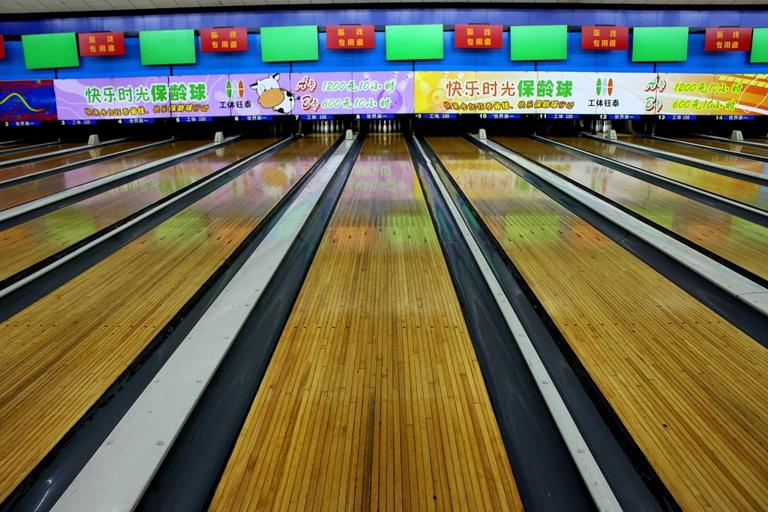

In [161]:
image

In [199]:
context = "How many apply in this picture"
device = "cuda:7"

In [200]:
question = DEFAULT_IMAGE_TOKEN + "\n" + context

In [219]:
image_tensor = process_images([image], image_processor, model.config)

In [220]:
model.config.image_aspect_ratio

'pad'

In [221]:
image_tensor = image_tensor.to(dtype=torch.float16, device=device)

In [222]:
conv = conv_templates["phi35"].copy()

In [223]:
conv.append_message(conv.roles[0], question)
conv.append_message(conv.roles[1], None)
prompt_question = conv.get_prompt()

In [224]:
prompt_question

'<|system|>\nYou are a helpful assistant.<|end|>\n<|user|>\n<image>\nHow many apply in this picture<|end|>\n<|assistant|>\n'

In [225]:
gen_kwargs = {}

In [226]:
gen_kwargs["image_sizes"] = [image.size]

In [227]:
gen_kwargs["max_new_tokens"] = 1024

In [228]:
gen_kwargs["temperature"] = 0

In [229]:
gen_kwargs["top_p"] = None

In [230]:
gen_kwargs["num_beams"] = 1

In [231]:
input_ids = tokenizer_image_token(question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(model.device)

In [232]:
pad_token_ids = tokenizer.eos_token_id

In [233]:
from transformers import TextStreamer


In [234]:
stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
keywords = [stop_str]
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

In [235]:
def pad_sequence(input_ids, batch_first, padding_value):
    if tokenizer.padding_side == "left":
        input_ids = [torch.flip(_input_ids, [0]) for _input_ids in input_ids]
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=batch_first, padding_value=padding_value)
    if tokenizer.padding_side == "left":
        input_ids = torch.flip(input_ids, [1])
    return input_ids


In [236]:
with torch.inference_mode():
    output_ids = model.generate(
        input_ids,
        images=image_tensor,  # Ensure the image tensor is on the same device and in half precision
        image_sizes=[image.size],
        do_sample=False,
        temperature=0,
        # top_p=args.top_p,
        num_beams=1,
        # no_repeat_ngram_size=3,
        max_new_tokens=1024,
        pad_token_id=tokenizer.eos_token_id,
        use_cache=True,
        return_id_experts=False
    )

/home/anonymous/miniconda3/envs/moe_new/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [237]:
output_ids[0]

tensor([[ 4856,  5697,  1274,  ...,  7707, 29887,  7707]], device='cuda:7')

In [241]:
text_outputs = tokenizer.decode(output_ids[0][0], skip_special_tokens=True)

In [ ]:
text_outputs

"someone pet ac pet ing pet ing pet ing pet ing pet ing ingent comprant']pet ingddddddspring']petddinterengddiermerampentier']merantion']ampmerindiententampregententampiggerentampnragent']ampmerphrdelionpatrpampstrpatampstrpatampstrpatampstrpatampstrpatampstrpatampstrpatampstrpatampstrpatampstrgrampplampgrpgpgpgpgpgpgpgpgpgpgpgpgpgpgpgpgpgpgpgpgpgpgpgpgpgpgpgpgpgpgpgpgpgrgpgpgpgrgpgpgrgpgpgrgpgpgrgpgpggrpgpggrgpgpggrpgpggrpgpgpgpgrgpgpgrgpgpggrpgpgpgrgpgpgpggrpgpgpgpgpgpgpgpgpgrgpgpgpgrgpgpggrpgpgrgpgpgrgpgpgrgpgpgpgrgpgpgrgpgpgpggrpgpgpgrgpgpgrgpgpgrgpgpggrogpgpgrgpgpggrogpgpgrgpgpggrpgpgpggpgrgpgpggrgpgpggrgpgpggrgpgpgrgpgpggrpgpgpgrgpgpgrgpgpgpgrgpgpgegrgpgpggramgpgpgegrgpgpgegrgpgpgeggrampgeggpgpgeggrampgegpgpggpgegpgpgpggpgpgegpgpgpggpgpgpggpgpggpgpggpgpggpgpggpggpgpggpgpggpgpgpggpgpggpgpggpgpggpgpggpgpgpggpgpgpgpggpgpgpggpgpggpgpgpggpggpggpgpggpggpgpggpgpggpggpgpggpggpggpggpggpggpggpggpggpgpggpggrgpgpggrgpgpggrgpgegrgpgegrgpgegdrgeggdrgegdrgegdrgdrgegdrgdrgegdrgegdrgeneogdrgeneeg

: 

In [191]:
import argparse
import torch

from moe_model.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from moe_model.conversation import conv_templates, SeparatorStyle
from moe_model.model.builder import load_pretrained_model
from moe_model.utils import disable_torch_init
from moe_model.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path

from PIL import Image

import requests
from PIL import Image
from io import BytesIO
from transformers import TextStreamer


In [192]:
def load_image(image_file):
    if image_file.startswith('http://') or image_file.startswith('https://'):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    return image

In [193]:
disable_torch_init()
